In [ ]:
# installing additional packages
%conda install pytorch torchvision torchaudio cpuonly -c pytorch
%pip install torchmetrics
%pip install torchinfo
%pip install kaggle

In [3]:
import os
import torch
import pandas as pd
import torchvision.transforms as transforms
import torchvision

from torch import Tensor
from pathlib import Path
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy
from torchinfo import summary

from PIL import Image


2024-05-31 10:33:40.951509: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Installing dataseet

!kaggle datasets download -d jay7080dev/rice-plant-diseases-dataset

!ls

import zipfile
import os

def unzip_file(zip_filepath, extract_to_dir):
    # Ensure the directory to extract to exists
    if not os.path.exists(extract_to_dir):
        os.makedirs(extract_to_dir)

    # Open the zip file
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        # Extract all the contents
        zip_ref.extractall(extract_to_dir)
    print(f"Extracted all files to {extract_to_dir}")

# Example usage
zip_filepath = './rice-plant-diseases-dataset.zip'
extract_to_dir = './data'
unzip_file(zip_filepath, extract_to_dir)


Dataset URL: https://www.kaggle.com/datasets/jay7080dev/rice-plant-diseases-dataset
License(s): Apache 2.0
100%|████████████████████████████████████████| 176M/176M [00:13<00:00, 18.9MB/s]
100%|████████████████████████████████████████| 176M/176M [00:13<00:00, 14.0MB/s]
'=2.1.1'			  environment.yml
 classification-excercise.ipynb   linear_regression.ipynb
 classification.ipynb		  papers
 computer-vision.ipynb		  readme.md
 custom_datasets.ipynb		  rice-plant-diseases-dataset.zip
 data				  rice_leaf_plant_disease_classifier.ipynb
 digit-recognizer.ipynb
Extracted all files to ./data


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
DATASET_FOLDER = Path("data/rice leaf diseases dataset")
DATASET_FOLDER.is_dir()

True

In [9]:
df = {"image": [], "label": []}
for root, dir, file in os.walk(DATASET_FOLDER):
    if len(file) > 0:
        for f in file:
            p = Path(root) / f
            df["image"].append(str(p))
            df["label"].append(p.parent.name)

In [10]:
df = pd.DataFrame(df)
y = df.loc[:, ["label"]]
X = df.drop(["label"],axis=1)

print(X.shape, y.shape)

(4684, 1) (4684, 1)


In [11]:
class_names = {}
i = 0
for d in DATASET_FOLDER.iterdir():
  class_names[d.name] = i
  i = i + 1

class_names

{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3747, 1) (3747, 1) (937, 1) (937, 1)


In [13]:
class CMYKToRGB(object):
    def __call__(self, img: Image.Image) -> Image.Image:
        if img.mode == 'RGBA' or img.mode == "CMYK":
            img = img.convert('RGB')
        return img

    def __repr__(self):
        return self.__class__.__name__ + '()'


transform = transforms.Compose([
    CMYKToRGB(),
    transforms.Resize((224, 224)),
    transforms.PILToTensor()
])


In [14]:

class CustomImageDataset(Dataset):
    def __init__(self, X: pd.DataFrame, y: pd.DataFrame, transform=transform) -> None:
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index: int) -> tuple[Tensor, str]:
        p = str(self.X.iloc[index, 0])
        label = str(self.y.iloc[index, 0])

        img: Tensor = self.transform(Image.open(p)) # type: ignore
        return img, class_names[label]

In [15]:
IN_CHANNELS = 3
OUT_FEATURES = 3
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE  = 32
TOTAL_TRAIN_BATCHES = y_train.shape[0] // TRAIN_BATCH_SIZE + \
    (1 if y_train.shape[0] % TRAIN_BATCH_SIZE != 0 else 0)
TOTAL_TEST_BATCHES = y_test.shape[0] // TEST_BATCH_SIZE + \
    (1 if y_test.shape[0] % TEST_BATCH_SIZE != 0 else 0)

print((TOTAL_TRAIN_BATCHES, TRAIN_BATCH_SIZE, IN_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
print((TOTAL_TEST_BATCHES, TEST_BATCH_SIZE, IN_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))

(118, 32, 3, 224, 224)
(30, 32, 3, 224, 224)


In [16]:
train_dataset = CustomImageDataset(X_train, y_train)
test_dataset = CustomImageDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, num_workers=2)
test_dataloader = DataLoader(
    test_dataset, TEST_BATCH_SIZE, shuffle=True, num_workers=2)

In [17]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /home/sagemaker-user/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 299MB/s]


In [18]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [19]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=OUT_FEATURES,
                    bias=True)).to(device)

In [21]:
loss_fn = nn.CrossEntropyLoss().to(device)
accuracy = Accuracy(task="multiclass",num_classes=3).to(device)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

In [22]:
from tqdm.auto import tqdm
torch.manual_seed(42)
epochs = 5



for epoch in tqdm(range(1, epochs+1)):
    train_loss = 0
    train_acc = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()

        X = X.type(torch.float32).to(device)
        y = y.to(device)

        y_logits = model(X)
        y_preds = torch.softmax(y_logits, dim=1)

        l = loss_fn(y_logits, y)
        train_loss += l.item()

        optimizer.zero_grad()

        l.backward()

        optimizer.step()

        train_acc += accuracy(y_preds, y)

    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)

    test_loss = 0
    test_acc = 0
    for batch, (X, y) in enumerate(test_dataloader):
        model.eval()

        with torch.inference_mode():
            X = X.type(torch.float32).to(device)
            y_test = y.to(device)

            y_test_logits = model(X)
            y_test_preds = torch.softmax(y_test_logits, dim=1)

            l = loss_fn(y_test_logits, y_test)
            test_loss += l.item()
            test_acc += accuracy(y_test_preds, y_test)

    test_loss_1 = test_loss / len(test_dataloader)
    test_acc_1 = test_acc / len(test_dataloader)

    print(f"epoch: {epoch} | train_loss: {train_loss} | train_acc: {train_acc} | test_loss: {test_loss_1} | test_acc: {test_acc_1}")

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 1 | train_loss: 0.5520812718797539 | train_acc: 0.804290235042572 | test_loss: 0.3029055312275887 | test_acc: 0.921759307384491


KeyboardInterrupt: 

In [ ]:
def find_key(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None

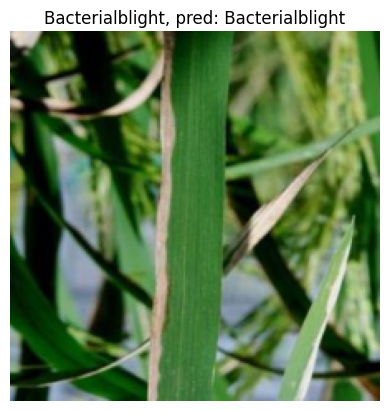

In [ ]:
import matplotlib.pyplot as plt
img, lbl =test_dataset[350]

img =img.unsqueeze(dim=0)
img = img.type(torch.float32).to(device)

model.eval()

with torch.inference_mode():
  predicted_image = model(img)

lbl = find_key(class_names, lbl)
pred_label = find_key(class_names, torch.argmax(predicted_image,dim=1).item())

img = img.type(torch.int).cpu().numpy()

plt.imshow(img[0].transpose(1,2,0))


plt.title(f"{lbl}, pred: {pred_label}")
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "rice-leaf=plant-disease-classifier.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)